# Overfitting in classification

In this project we aim to investigate overfitting in classification models.

## MNIST Data

In [7]:
import numpy as np
import pandas as pd

- First of all load the MNIST dataset using `mnist.load_data()`
- Then reshape the images from (28, 28) to 784 array.
- Construct a DataFrame and store the data in that.
- As we can see, there are 60000 samples for train and 10000 samples for test.

In [8]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape the images to flat arrays
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Create DataFrames
mnist_train = pd.DataFrame(train_images_flat)
mnist_train['label'] = train_labels

mnist_test = pd.DataFrame(test_images_flat)
mnist_test['label'] = test_labels

print(f"number of train samples: {mnist_train.shape[0]}\nnumber of test samples: {mnist_test.shape[0]}")
print(f"number of featrues (pixels) for each sample: {mnist_train.shape[1]-1}")

number of train samples: 60000
number of test samples: 10000
number of featrues (pixels) for each sample: 784


## Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler

We use `MinMaxScaler.fit_transform()` and `MinMaxScaler.transform()` to scale the columns related to the pixels in range [0, 1] using min-max normalization.

- `MinMaxScaler.fit_transform()`: It is used to scale the train data. It fits an algorithem for scaling the data.
- `MinMaxScaler.transform()`: It is used to scale the test data. In fact, `.trasform` scale the data, as same as how it's done to train data.
- Scaling ensures that all features are treated equally during training.
- If features have different scales (some large, some small), those with larger values can overshadow others, leading to biased learning.
- Scaling makes all features have similar ranges, preventing any single feature from dominating the learning process and promoting fair training.
- Large input values can cause numerical instability in certain activation functions or loss functions.

In [10]:
scaler = MinMaxScaler()

# Scale the data using MinMaxScaler
mnist_train[mnist_train.columns[:-1]]= scaler.fit_transform(mnist_train[mnist_train.columns[:-1]])
mnist_test[mnist_test.columns[:-1]] = scaler.transform(mnist_test[mnist_test.columns[:-1]])

## One Hot encoding

- To have a accurate and rational fully connected model, we have to encode the labels using One Hot encoding.
- So the outputs will be in 10 classes making the model training process easier and less expensive.
- It is done by using `pd.get_dummies()`.
- First of all, we have changed the type of label column in both train and test set to string.
- So that using `pd.get_dummies()` we do One Hot encoding on string columns.

In [11]:
mnist_train['label'] = mnist_train['label'].astype('string')
mnist_test['label'] = mnist_test['label'].astype('string')

# Encode the target labels to One Hot encoding for both train and test data.
mnist_train = pd.get_dummies(mnist_train, prefix_sep='_')
mnist_test = pd.get_dummies(mnist_test, prefix_sep='_')

print(f"number of columns after using one hot encoding for both train and test set:\ntrian set = {len(mnist_train.columns)}\ntest set = {len(mnist_test.columns)}")

number of columns after using one hot encoding for both train and test set:
trian set = 794
test set = 794


## Training

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

Set the random seed so that in different executions, we get the same results.

In [ ]:
tf.random.set_seed(42)

Split the X (input) and y (output) from the data to use in training the models.

In [ ]:
# Split the data to X and y
X_train = mnist_train.iloc[:, :-10]
y_train = mnist_train.iloc[:, -10:]
X_test = mnist_test.iloc[:, :-10]
y_test = mnist_test.iloc[:, -10:]

### Train data increasing

This function is used to train the models with different percentage of train data.
- For each percentage (0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95):
- Get the train data based on the percentage.
- Construct a three layer fully connected model with 784 neurons in input layer, 256, 64 neurons in hidden and 10 neurons in output layer.
- Set the learning rate to 6e-5 with Adam optimizer.
- And loss to CrossEntropy.
- Fit the data with some of train data.
- Get the accuracy and losses for train, validation and test set.

In [ ]:
def data_increasing_compile(X_train, y_train, X_test, y_test):

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for per in np.arange(0.05, 1, 0.15):
        
        # Get the data based on percentage
        X = X_train.iloc[:int(per*X_train.shape[0])]
        y = y_train.iloc[:int(per*y_train.shape[0])]

        # Construct a three layer fully connected model
        FC_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, input_shape=(784,), activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
        ])

        # Compile the model
        FC_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=6e-5),
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])

        # fit the model with some of train data
        history = FC_model.fit(X, y, epochs=25, validation_split=0.1)
        history_df = pd.DataFrame(history.history)

        # get the test accuracy and loss
        test_loss, test_acc = FC_model.evaluate(X_test, y_test)

        train_losses.append(history_df['loss'])
        train_accs.append(history_df['accuracy'])
        val_losses.append(history_df['val_loss'])
        val_accs.append(history_df['val_accuracy'])
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    return train_losses, train_accs, val_losses, val_accs, test_losses, test_accs

In [ ]:
train_losses, train_accs, val_losses, val_accs, test_losses, test_accs = data_increasing_compile(X_train, y_train, X_test, y_test)

Epoch 1/25
85/85 [==============================] - 2s 10ms/step - loss: 2.1288 - accuracy: 0.2411 - val_loss: 1.9090 - val_accuracy: 0.4567
Epoch 2/25
85/85 [==============================] - 1s 6ms/step - loss: 1.6594 - accuracy: 0.6063 - val_loss: 1.4357 - val_accuracy: 0.6700
Epoch 3/25
85/85 [==============================] - 1s 6ms/step - loss: 1.2308 - accuracy: 0.7504 - val_loss: 1.0722 - val_accuracy: 0.7733
Epoch 4/25
85/85 [==============================] - 1s 6ms/step - loss: 0.9279 - accuracy: 0.8170 - val_loss: 0.8410 - val_accuracy: 0.8000
Epoch 5/25
85/85 [==============================] - 1s 6ms/step - loss: 0.7318 - accuracy: 0.8515 - val_loss: 0.6969 - val_accuracy: 0.8300
Epoch 6/25
85/85 [==============================] - 0s 6ms/step - loss: 0.6075 - accuracy: 0.8744 - val_loss: 0.6038 - val_accuracy: 0.8467
Epoch 7/25
85/85 [==============================] - 0s 6ms/step - loss: 0.5263 - accuracy: 0.8848 - val_loss: 0.5458 - val_accuracy: 0.8467
Epoch 8/25
85/85 [=

As we can see the results in 6 different plots, As the data for training increases:
1. Accuracy for train and validation set starts at higher rate.
2. Accuracy for train and validation set goes higher and gets larger.
3. And also for losses, it starts from lower rate.
4. And it gets lower and lower by increasing the data for both train and validation set.
5. And as we can predict, the accuracy on test set increases by increasing the data.
6. And of course the loss on test set will decrease.

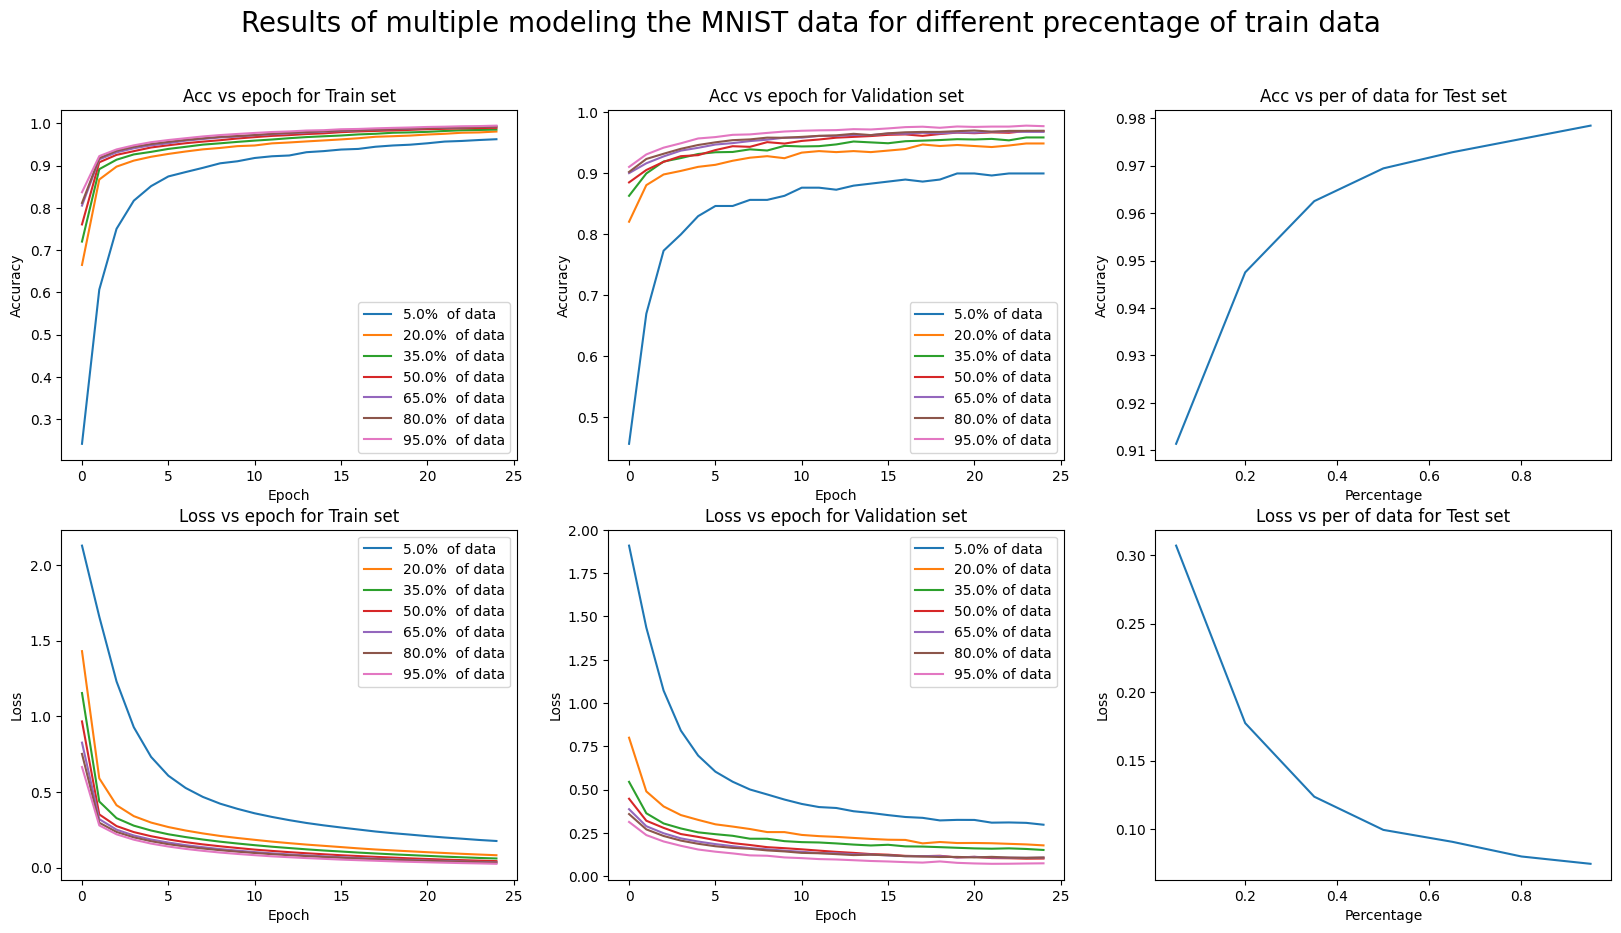

In [ ]:
# Plot the results of multiple modeling
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i, per in enumerate(np.arange(0.05, 1, 0.15)):
    axes.flat[0].plot(train_accs[i], label=f"{np.round(per, 2)*100}%  of data")
    axes.flat[1].plot(val_accs[i], label=f"{np.round(per, 2)*100}% of data")
    axes.flat[3].plot(train_losses[i], label=f"{np.round(per, 2)*100}%  of data")
    axes.flat[4].plot(val_losses[i], label=f"{np.round(per, 2)*100}% of data")

axes.flat[2].plot(np.arange(0.05, 1, 0.15), test_accs)
axes.flat[5].plot(np.arange(0.05, 1, 0.15), test_losses)

axes.flat[0].set_xlabel("Epoch")
axes.flat[1].set_xlabel("Epoch")
axes.flat[3].set_xlabel("Epoch")
axes.flat[4].set_xlabel("Epoch")
axes.flat[2].set_xlabel("Percentage")
axes.flat[5].set_xlabel("Percentage")

axes.flat[0].set_ylabel("Accuracy")
axes.flat[1].set_ylabel("Accuracy")
axes.flat[3].set_ylabel("Loss")
axes.flat[4].set_ylabel("Loss")
axes.flat[2].set_ylabel("Accuracy")
axes.flat[5].set_ylabel("Loss")

axes.flat[0].set_title("Acc vs epoch for Train set")
axes.flat[1].set_title("Acc vs epoch for Validation set")
axes.flat[3].set_title("Loss vs epoch for Train set")
axes.flat[4].set_title("Loss vs epoch for Validation set")
axes.flat[2].set_title("Acc vs per of data for Test set")
axes.flat[5].set_title("Loss vs per of data for Test set")

fig.suptitle('Results of multiple modeling the MNIST data for different precentage of train data', fontsize=20)

axes.flat[0].legend()
axes.flat[1].legend()
axes.flat[3].legend()
axes.flat[4].legend()
plt.show()

### layer increasing

This function is used to train the models with different number of hidden layers.
- For each number of layers (from 3 to 20):
- Construct the model based on the given number of hidden layers.
- The number of neurons uses different combinations of neurons. 
- Set the learning rate to 1e-5 with Adam optimizer.
- And loss to CrossEntropy.
- Fit the train data.
- Get the accuracy and losses for train, validation and test set.

In [ ]:
def layer_increasing_compile(X_train, y_train, X_test, y_test, layers):

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for i in range(3, 21):
        
        # Construct the model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(784, )))

        # Add hidden layers based on the layers given
        for j in range(0, len(layers), int(len(layers)/(i-1))):
            model.add(tf.keras.layers.Dense(layers[j], activation='relu'))

        # Add the output layer
        model.add(tf.keras.layers.Dense(10, activation='softmax'))

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss=tf.keras.losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])

        # Fit the model with train data
        history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)
        history_df = pd.DataFrame(history.history)

        # Get the accuracy and losses
        test_loss, test_acc = model.evaluate(X_test, y_test)

        train_losses.append(history_df['loss'])
        train_accs.append(history_df['accuracy'])
        val_losses.append(history_df['val_loss'])
        val_accs.append(history_df['val_accuracy'])
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"model with {i} layers, done!", end='\r', flush=True)

    return train_losses, train_accs, val_losses, val_accs, test_losses, test_accs

what is layers array:
- It determined different number of neurons for hidden layers in the model based on how many layers we want to have.
- For example, if we want to have 3 hidden layers, the layers have 750, 500, 250 layers respectively.

In [ ]:
layers = [750, 700, 650, 600, 550, 512, 500, 450, 400, 350, 300, 256, 250, 200, 150, 128, 64, 32, 16]

train_losses_l, train_accs_l, val_losses_l, val_accs_l, test_losses_l, test_accs_l = layer_increasing_compile(X_train, y_train, X_test, y_test, layers)

Epoch 1/10
1688/1688 [==============================] - 8s 4ms/step - loss: 1.3943 - accuracy: 0.5526 - val_loss: 0.7189 - val_accuracy: 0.8450
Epoch 2/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.6150 - accuracy: 0.8534 - val_loss: 0.4270 - val_accuracy: 0.9023
Epoch 3/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4350 - accuracy: 0.8927 - val_loss: 0.3267 - val_accuracy: 0.9198
Epoch 4/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3536 - accuracy: 0.9091 - val_loss: 0.2744 - val_accuracy: 0.9320
Epoch 5/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3040 - accuracy: 0.9209 - val_loss: 0.2389 - val_accuracy: 0.9382
Epoch 6/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2690 - accuracy: 0.9288 - val_loss: 0.2149 - val_accuracy: 0.9428
Epoch 7/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2427 - accuracy: 0.9357 - val_loss: 0.1971 - val_accuracy:

As we can see, increasing the number of hidden layers doesn't necessarily results to better model.
- The best results were captured while the number of hidden layers where aroud 8.
- increasing the layers a lot, might results to over fitting or a lot of parameters, so we might need much more data.

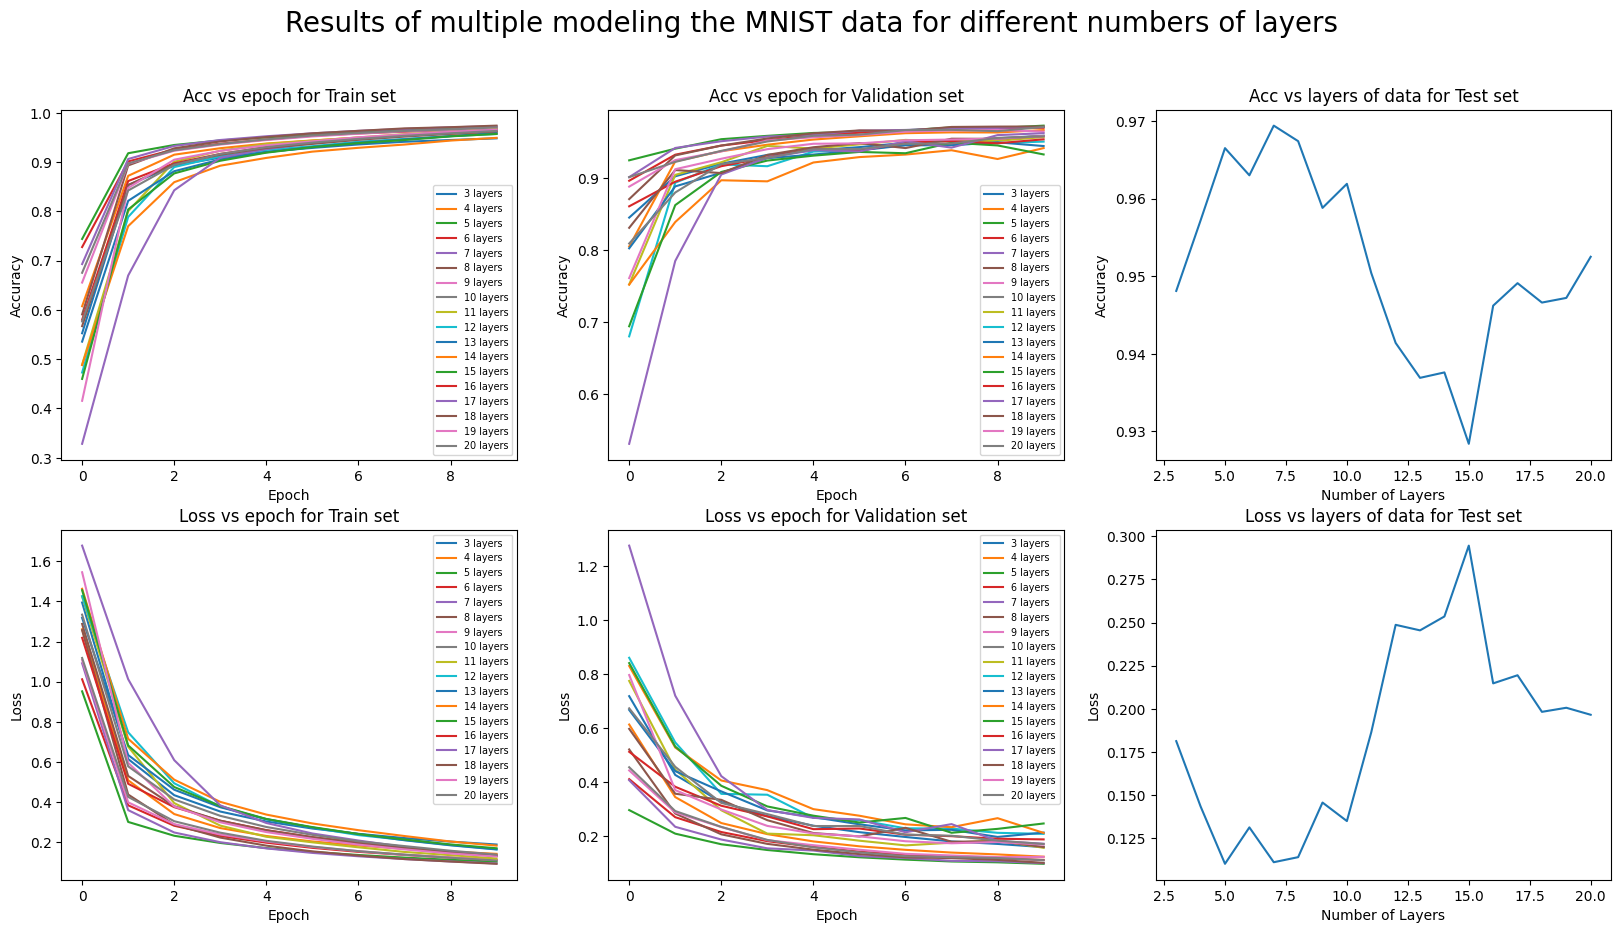

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i in range(18):
    axes.flat[0].plot(train_accs_l[i], label=f"{i+3} layers")
    axes.flat[1].plot(val_accs_l[i], label=f"{i+3} layers")
    axes.flat[3].plot(train_losses_l[i], label=f"{i+3} layers")
    axes.flat[4].plot(val_losses_l[i], label=f"{i+3} layers")

axes.flat[2].plot(range(3, 21), test_accs_l)
axes.flat[5].plot(range(3, 21), test_losses_l)

axes.flat[0].set_xlabel("Epoch")
axes.flat[1].set_xlabel("Epoch")
axes.flat[3].set_xlabel("Epoch")
axes.flat[4].set_xlabel("Epoch")
axes.flat[2].set_xlabel("Number of Layers")
axes.flat[5].set_xlabel("Number of Layers")

axes.flat[0].set_ylabel("Accuracy")
axes.flat[1].set_ylabel("Accuracy")
axes.flat[3].set_ylabel("Loss")
axes.flat[4].set_ylabel("Loss")
axes.flat[2].set_ylabel("Accuracy")
axes.flat[5].set_ylabel("Loss")

axes.flat[0].set_title("Acc vs epoch for Train set")
axes.flat[1].set_title("Acc vs epoch for Validation set")
axes.flat[3].set_title("Loss vs epoch for Train set")
axes.flat[4].set_title("Loss vs epoch for Validation set")
axes.flat[2].set_title("Acc vs layers of data for Test set")
axes.flat[5].set_title("Loss vs layers of data for Test set")

fig.suptitle('Results of multiple modeling the MNIST data for different numbers of layers', fontsize=20)

axes.flat[0].legend(fontsize='x-small')
axes.flat[1].legend(fontsize='x-small')
axes.flat[3].legend(fontsize='x-small')
axes.flat[4].legend(fontsize='x-small')
plt.show()

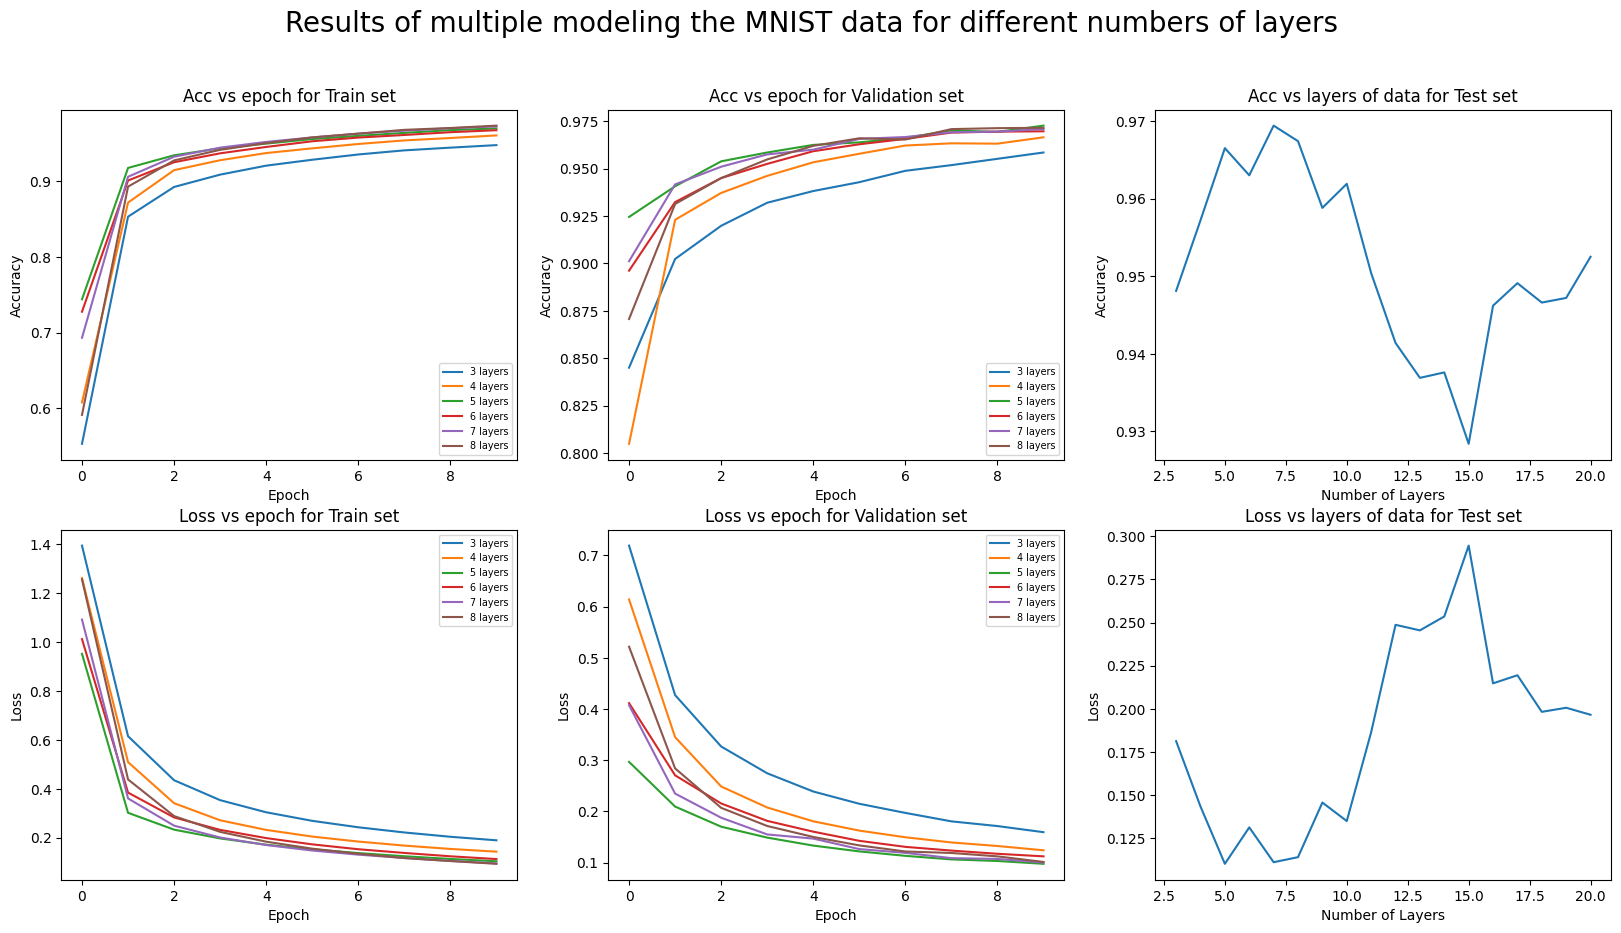

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i in range(0, 6):
    axes.flat[0].plot(train_accs_l[i], label=f"{i+3} layers")
    axes.flat[1].plot(val_accs_l[i], label=f"{i+3} layers")
    axes.flat[3].plot(train_losses_l[i], label=f"{i+3} layers")
    axes.flat[4].plot(val_losses_l[i], label=f"{i+3} layers")

axes.flat[2].plot(range(3, 21), test_accs_l)
axes.flat[5].plot(range(3, 21), test_losses_l)

axes.flat[0].set_xlabel("Epoch")
axes.flat[1].set_xlabel("Epoch")
axes.flat[3].set_xlabel("Epoch")
axes.flat[4].set_xlabel("Epoch")
axes.flat[2].set_xlabel("Number of Layers")
axes.flat[5].set_xlabel("Number of Layers")

axes.flat[0].set_ylabel("Accuracy")
axes.flat[1].set_ylabel("Accuracy")
axes.flat[3].set_ylabel("Loss")
axes.flat[4].set_ylabel("Loss")
axes.flat[2].set_ylabel("Accuracy")
axes.flat[5].set_ylabel("Loss")

axes.flat[0].set_title("Acc vs epoch for Train set")
axes.flat[1].set_title("Acc vs epoch for Validation set")
axes.flat[3].set_title("Loss vs epoch for Train set")
axes.flat[4].set_title("Loss vs epoch for Validation set")
axes.flat[2].set_title("Acc vs layers of data for Test set")
axes.flat[5].set_title("Loss vs layers of data for Test set")

fig.suptitle('Results of multiple modeling the MNIST data for different numbers of layers', fontsize=20)

axes.flat[0].legend(fontsize='x-small')
axes.flat[1].legend(fontsize='x-small')
axes.flat[3].legend(fontsize='x-small')
axes.flat[4].legend(fontsize='x-small')
plt.show()

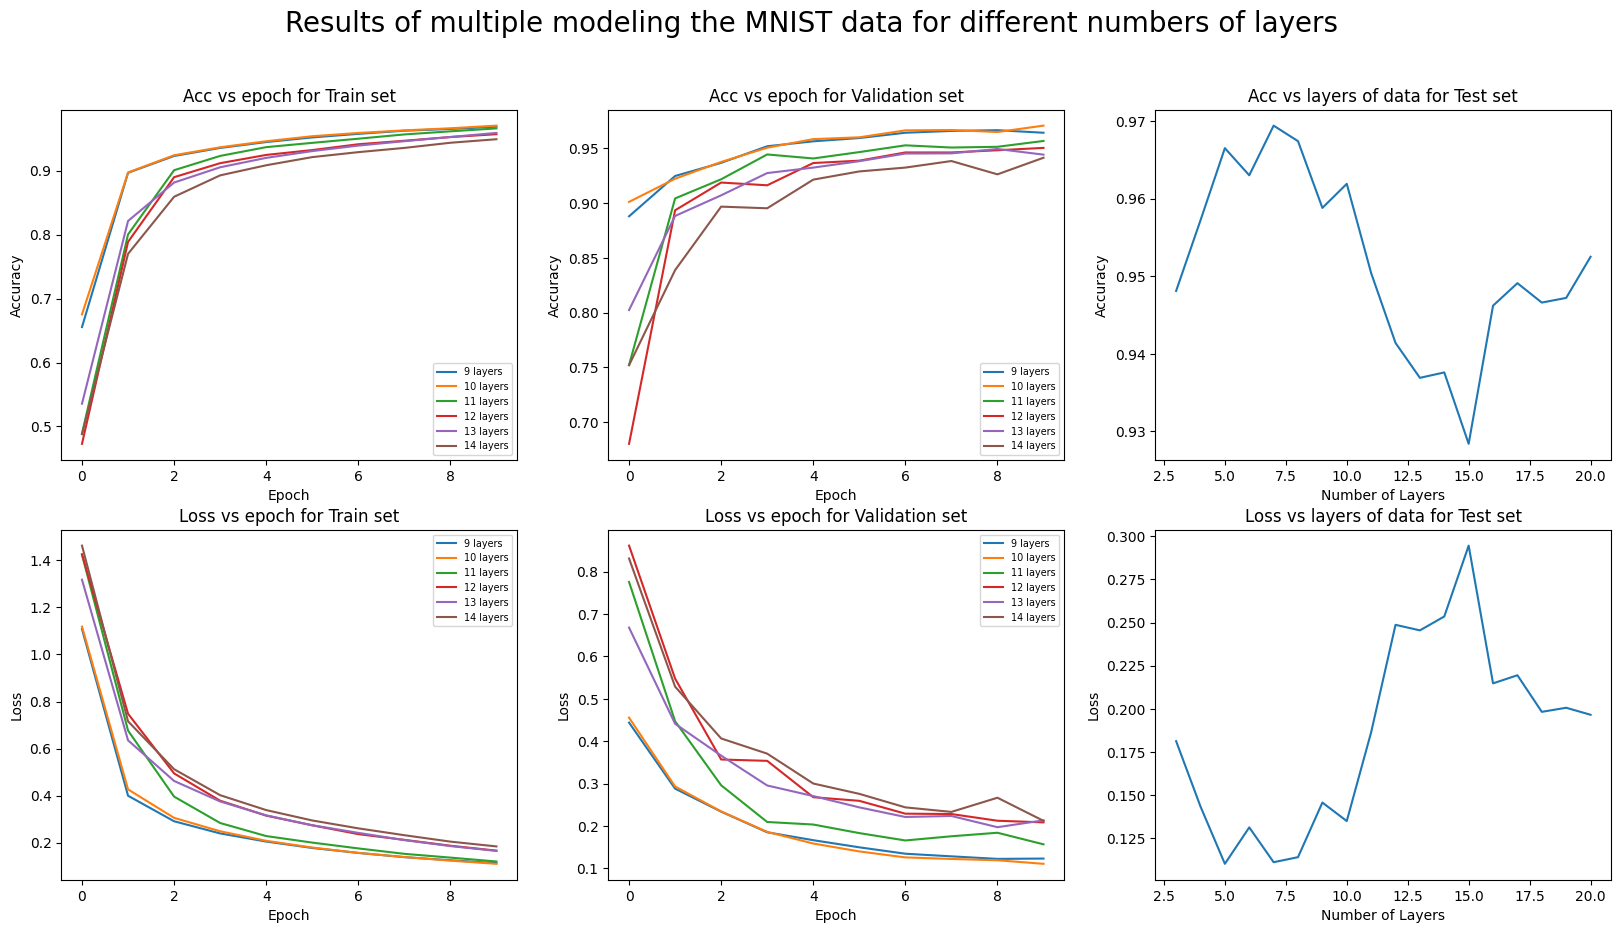

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i in range(6, 12):
    axes.flat[0].plot(train_accs_l[i], label=f"{i+3} layers")
    axes.flat[1].plot(val_accs_l[i], label=f"{i+3} layers")
    axes.flat[3].plot(train_losses_l[i], label=f"{i+3} layers")
    axes.flat[4].plot(val_losses_l[i], label=f"{i+3} layers")

axes.flat[2].plot(range(3, 21), test_accs_l)
axes.flat[5].plot(range(3, 21), test_losses_l)

axes.flat[0].set_xlabel("Epoch")
axes.flat[1].set_xlabel("Epoch")
axes.flat[3].set_xlabel("Epoch")
axes.flat[4].set_xlabel("Epoch")
axes.flat[2].set_xlabel("Number of Layers")
axes.flat[5].set_xlabel("Number of Layers")

axes.flat[0].set_ylabel("Accuracy")
axes.flat[1].set_ylabel("Accuracy")
axes.flat[3].set_ylabel("Loss")
axes.flat[4].set_ylabel("Loss")
axes.flat[2].set_ylabel("Accuracy")
axes.flat[5].set_ylabel("Loss")

axes.flat[0].set_title("Acc vs epoch for Train set")
axes.flat[1].set_title("Acc vs epoch for Validation set")
axes.flat[3].set_title("Loss vs epoch for Train set")
axes.flat[4].set_title("Loss vs epoch for Validation set")
axes.flat[2].set_title("Acc vs layers of data for Test set")
axes.flat[5].set_title("Loss vs layers of data for Test set")

fig.suptitle('Results of multiple modeling the MNIST data for different numbers of layers', fontsize=20)

axes.flat[0].legend(fontsize='x-small')
axes.flat[1].legend(fontsize='x-small')
axes.flat[3].legend(fontsize='x-small')
axes.flat[4].legend(fontsize='x-small')
plt.show()

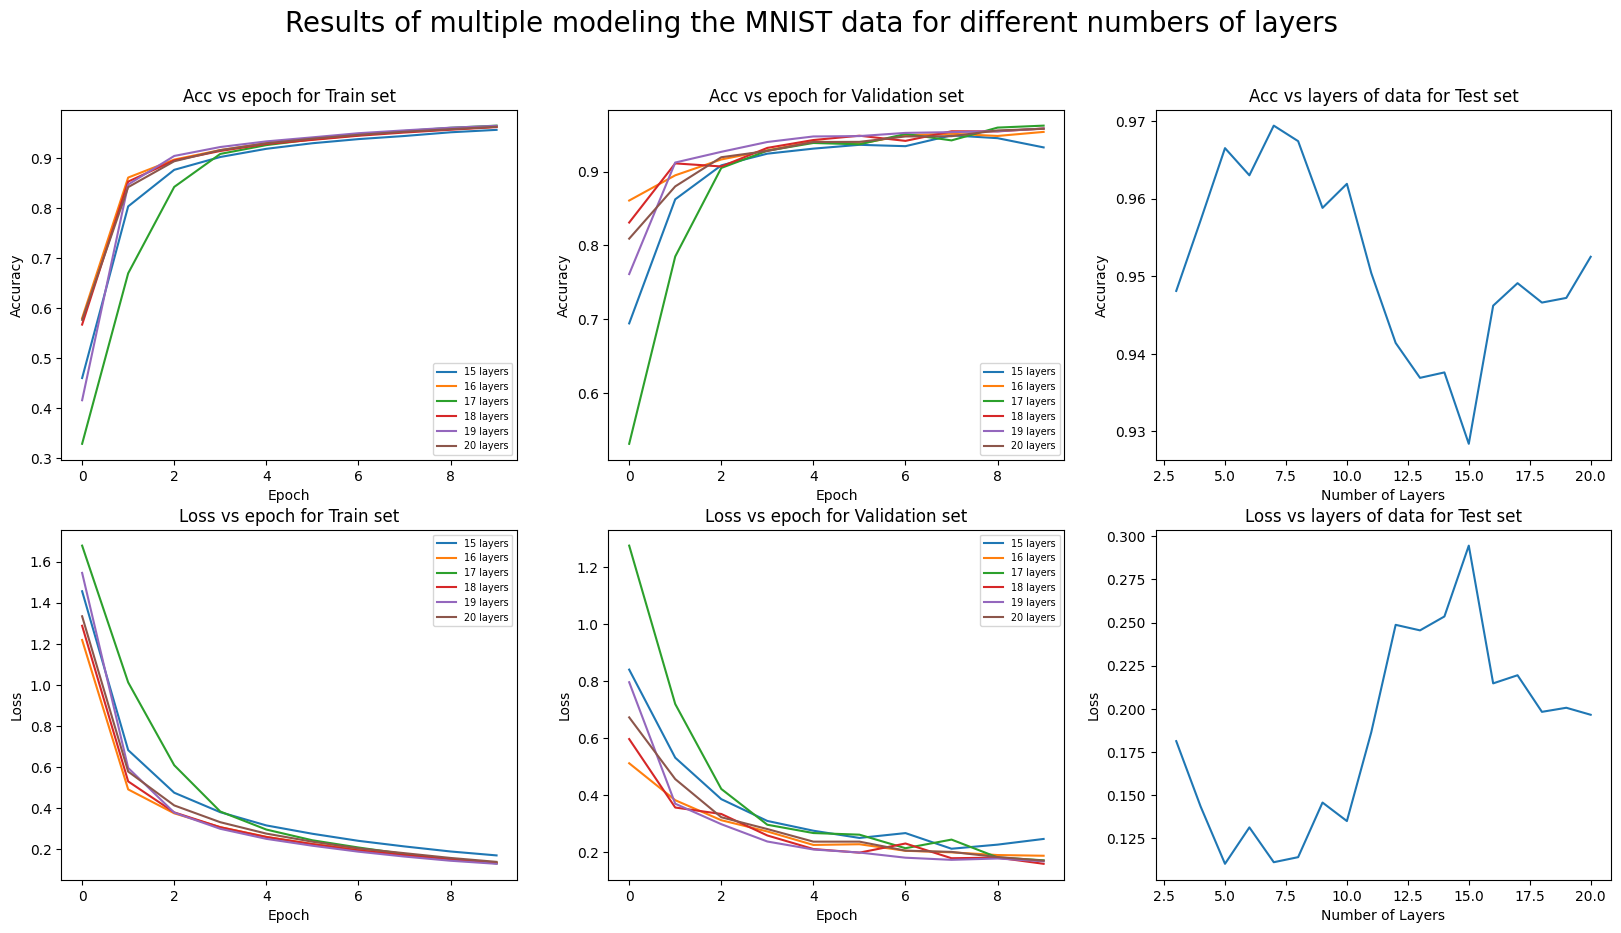

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i in range(12, 18):
    axes.flat[0].plot(train_accs_l[i], label=f"{i+3} layers")
    axes.flat[1].plot(val_accs_l[i], label=f"{i+3} layers")
    axes.flat[3].plot(train_losses_l[i], label=f"{i+3} layers")
    axes.flat[4].plot(val_losses_l[i], label=f"{i+3} layers")

axes.flat[2].plot(range(3, 21), test_accs_l)
axes.flat[5].plot(range(3, 21), test_losses_l)

axes.flat[0].set_xlabel("Epoch")
axes.flat[1].set_xlabel("Epoch")
axes.flat[3].set_xlabel("Epoch")
axes.flat[4].set_xlabel("Epoch")
axes.flat[2].set_xlabel("Number of Layers")
axes.flat[5].set_xlabel("Number of Layers")

axes.flat[0].set_ylabel("Accuracy")
axes.flat[1].set_ylabel("Accuracy")
axes.flat[3].set_ylabel("Loss")
axes.flat[4].set_ylabel("Loss")
axes.flat[2].set_ylabel("Accuracy")
axes.flat[5].set_ylabel("Loss")

axes.flat[0].set_title("Acc vs epoch for Train set")
axes.flat[1].set_title("Acc vs epoch for Validation set")
axes.flat[3].set_title("Loss vs epoch for Train set")
axes.flat[4].set_title("Loss vs epoch for Validation set")
axes.flat[2].set_title("Acc vs layers of data for Test set")
axes.flat[5].set_title("Loss vs layers of data for Test set")

fig.suptitle('Results of multiple modeling the MNIST data for different numbers of layers', fontsize=20)

axes.flat[0].legend(fontsize='x-small')
axes.flat[1].legend(fontsize='x-small')
axes.flat[3].legend(fontsize='x-small')
axes.flat[4].legend(fontsize='x-small')
plt.show()